<a href="https://colab.research.google.com/github/arjunverma2004/Capuchinbird_calls_classification/blob/main/notebooks/Capuchinbird_calls_AudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import and Install Dependencies

## 1.1 Install Data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kenjee/z-by-hp-unlocked-challenge-3-signal-processing")

print("Path to dataset files:", path)

100%|██████████| 604M/604M [00:28<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing/versions/1


In [ ]:
import shutil
import os

# The path variable holds the download location from the previous cell
download_path = path
destination_path = 'data'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Copy the contents of the downloaded directory to the destination directory
shutil.copytree(download_path, destination_path, dirs_exist_ok=True)

print(f"Dataset copied from {download_path} to {destination_path}")

Dataset copied from /root/.cache/kagglehub/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing/versions/1 to data


## 1.2 Load Dependencies

In [18]:
!pip install tensorflow-io==0.37.1

In [23]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
#import tensorflow_io as
import librosa
import numpy as np

In [3]:
print(tf.__version__)

2.18.0


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [24]:
#Checking for single file first
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [72]:
import librosa
import numpy as np
import tensorflow as tf

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Use tf.numpy_function to wrap librosa.resample
    # This allows using librosa within the TensorFlow graph context
    def _resample_numpy(wav_np, sample_rate_np):
        return librosa.resample(wav_np, orig_sr=sample_rate_np, target_sr=16000)

    # Ensure the inputs to numpy_function are tensors
    wav = tf.numpy_function(
        func=_resample_numpy,
        inp=[wav, sample_rate],
        Tout=tf.float32)

    return wav

## 2.3 Plot Wave

In [73]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

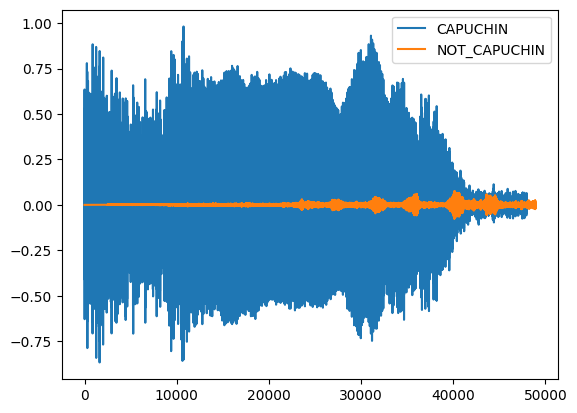

In [74]:
line1, = plt.plot(wave)
line2, = plt.plot(nwave)
plt.legend([line1, line2],['CAPUCHIN','NOT_CAPUCHIN'])
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [75]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [39]:
pos = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))

## 3.3 Add labels and Combine Positive and Negative Samples

In [115]:
# Function to add label to a file path
def add_label(file_path):
    # Determine label based on directory
    if tf.strings.regex_full_match(file_path, '.*Parsed_Capuchinbird_Clips.*'):
        return file_path, 1.0  # Use 1.0 for float32 label
    else:
        return file_path, 0.0  # Use 0.0 for float32 label

# Create datasets of file paths
pos_files = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg_files = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))

# Map the add_label function to create labeled datasets
positives = pos_files.map(add_label)
negatives = neg_files.map(add_label)

# Concatenate the labeled datasets
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [76]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [42]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [43]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [44]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [116]:
import tensorflow as tf

@tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.string),
                              tf.TensorSpec(shape=(), dtype=tf.float32)])
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram) #To get absolute values and get rid of negatives
    spectrogram = tf.expand_dims(spectrogram, axis=2) #to convert in the appropiate format of array so that we can feed it to NN
    spectrogram = tf.ensure_shape(spectrogram, (1491, 257, 1)) # Explicitly set the shape
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [109]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

In [110]:
filepath_neg, label_neg = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram_neg, label_neg = preprocess(filepath_neg, label_neg)

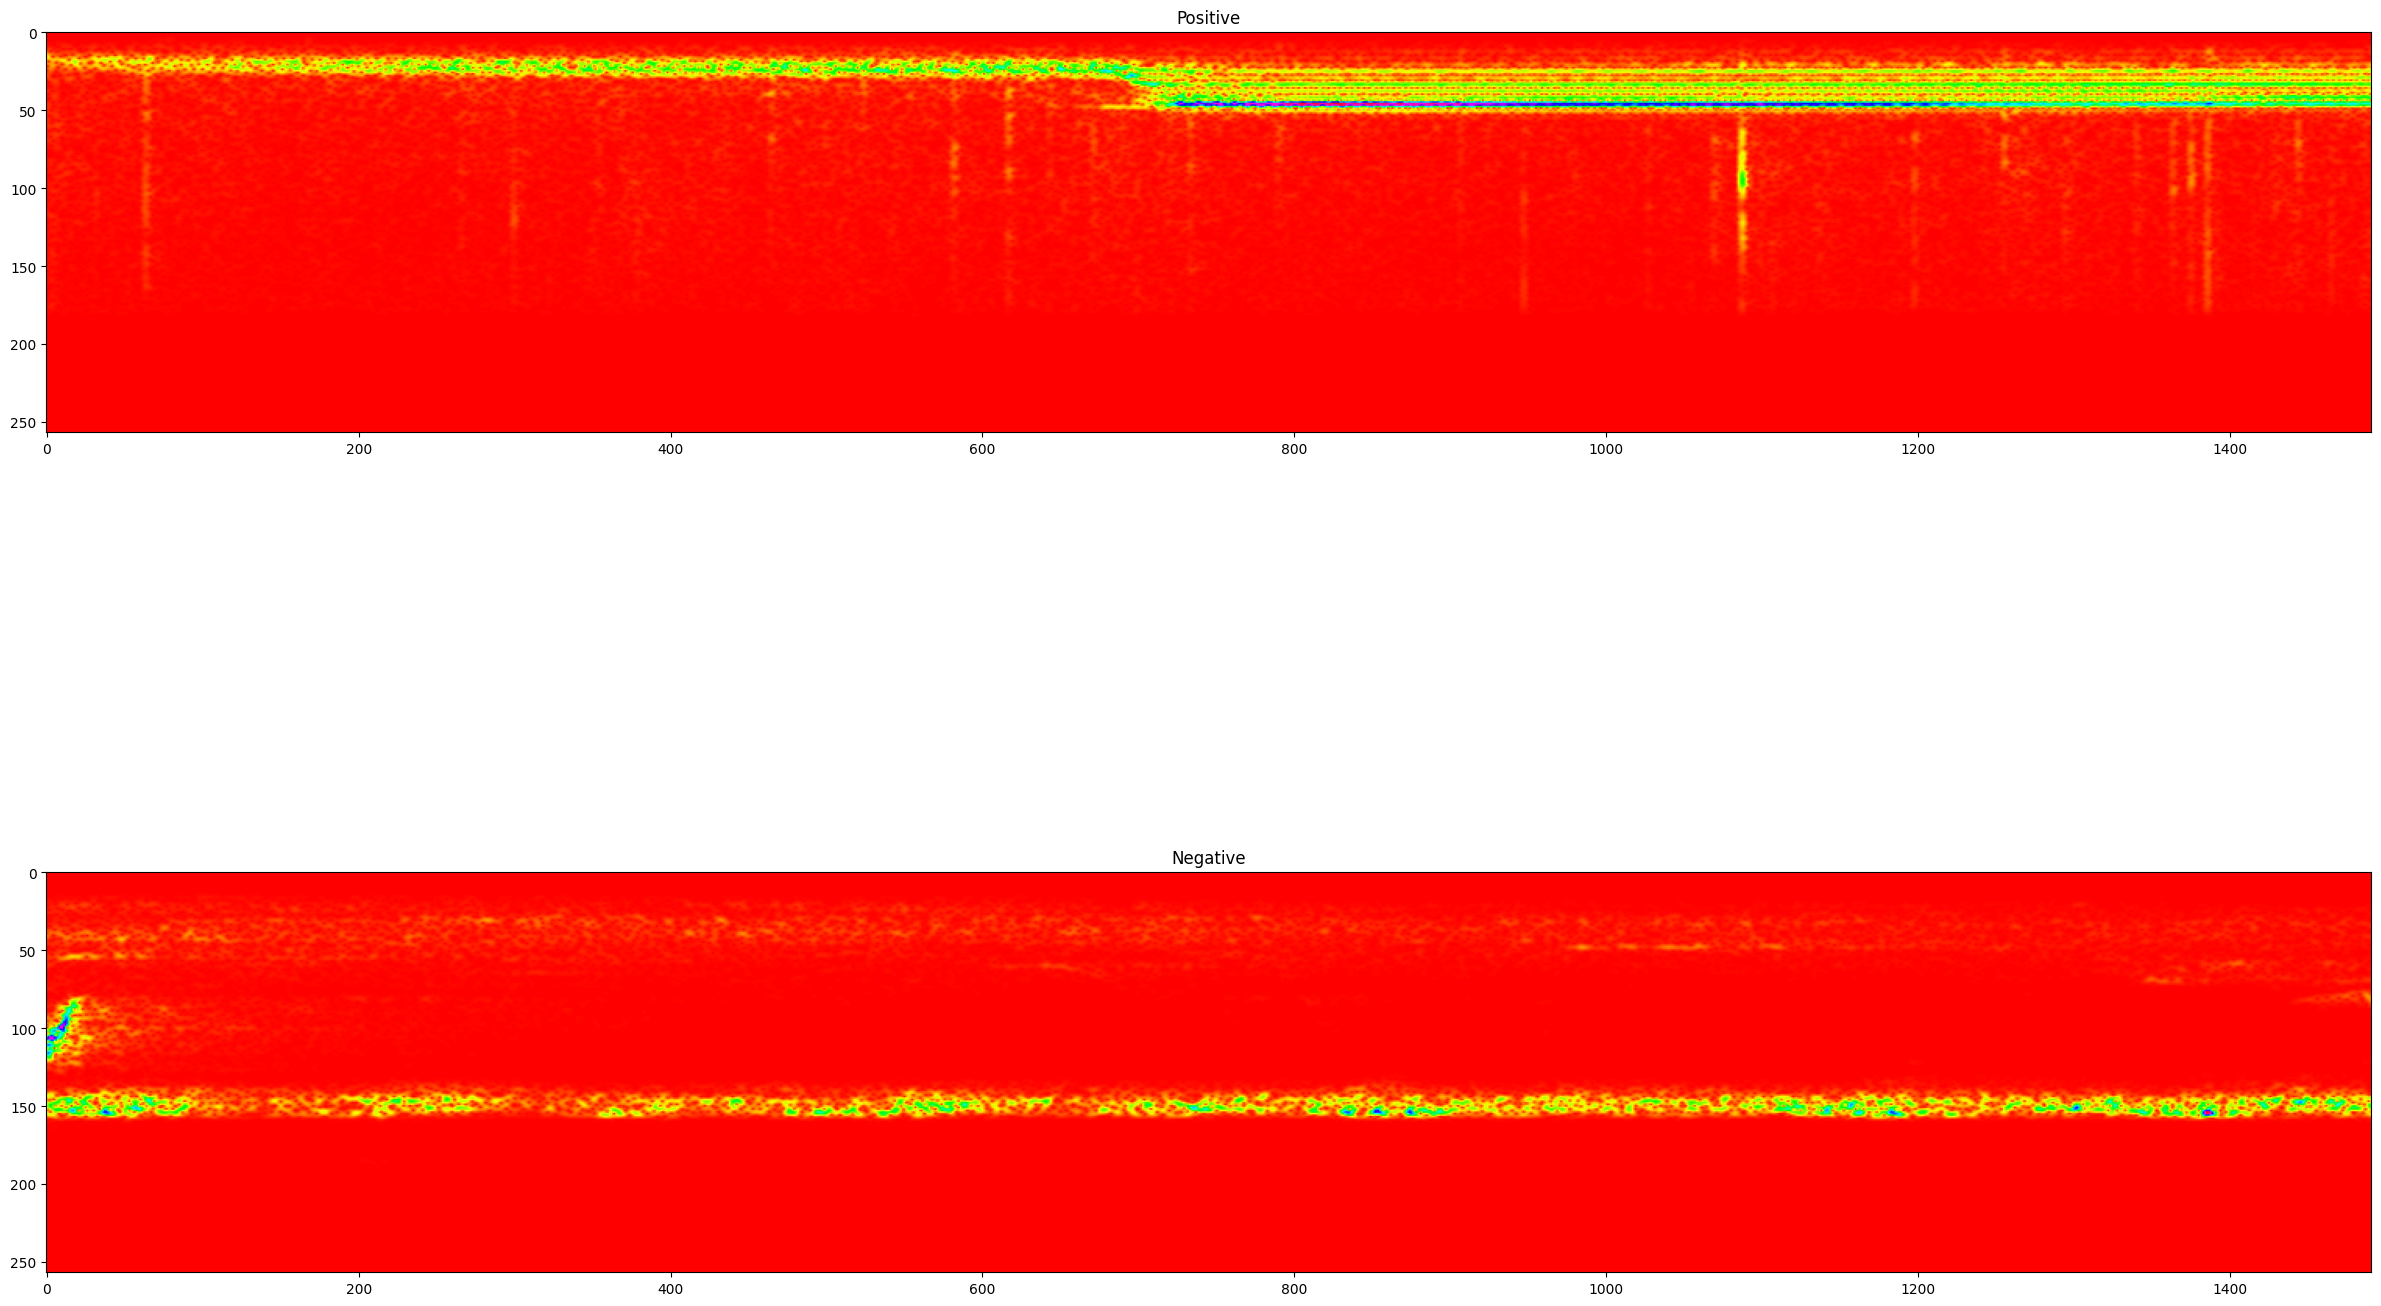

In [111]:
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(tf.transpose(spectrogram)[0],cmap = 'hsv')
plt.title('Positive')
plt.subplot(2,1,2)
plt.imshow(tf.transpose(spectrogram_neg)[0],cmap='hsv')
plt.title('Negative')
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [117]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [118]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [120]:
samples, labels = train.as_numpy_iterator().next()

In [121]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

## 7.2 Build Sequential Model, Compile and View Summary

In [123]:
from tensorflow.keras.layers import Input

model = Sequential()
# Explicitly define the input layer
model.add(Input(shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [124]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy'])

In [125]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 744, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 742, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 370, 62, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 367040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    46,981,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,983,857 (179.23 MB)

 Trainable params: 46,983,857 (179.23 MB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [127]:
history = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9994 - loss: 0.0024 - precision_5: 0.9997 - recall_5: 0.9983 - val_accuracy: 1.0000 - val_loss: 0.0098 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 1.0000 - loss: 0.0029 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 0.9957 - val_loss: 0.0080 - val_precision_5: 1.0000 - val_recall_5: 0.9846
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9978 - loss: 0.0087 - precision_5: 1.0000 - recall_5: 0.9910 - val_accuracy: 1.0000 - val_loss: 4.8286e-04 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 2.4797e-04 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.3045e-04 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 1.2057e-04 - precision_5: 1.0000 - recall_5: 1

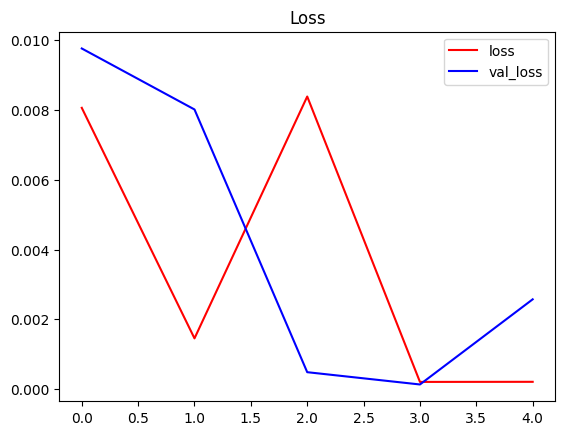

In [130]:
plt.title('Loss')
loss, =plt.plot(history.history['loss'], 'r')
val_loss, = plt.plot(history.history['val_loss'], 'b')
plt.legend([loss, val_loss],['loss', 'val_loss'])
plt.show()

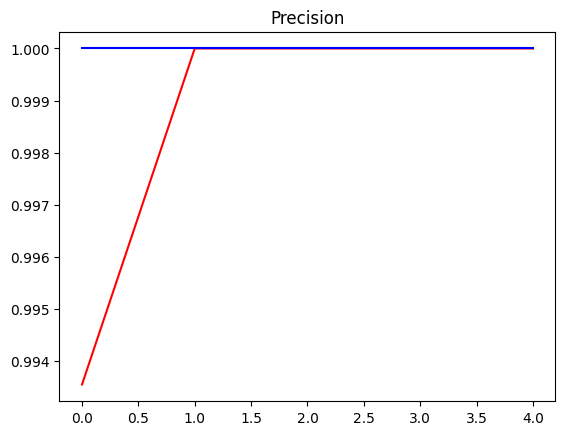

In [132]:
plt.title('Precision')
plt.plot(history.history['precision_5'], 'r')
plt.plot(history.history['val_precision_5'], 'b')
plt.show()

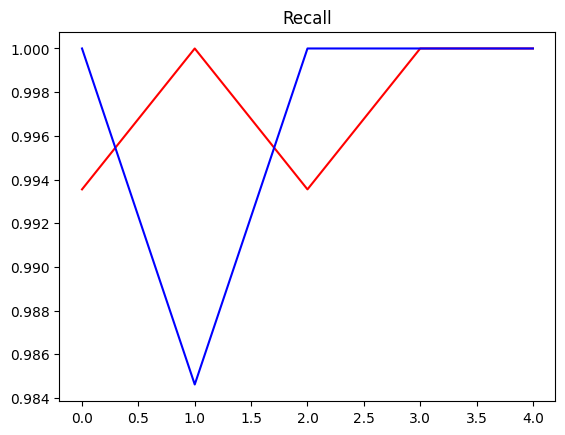

In [134]:
plt.title('Recall')
plt.plot(history.history['recall_5'], 'r')
plt.plot(history.history['val_recall_5'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [135]:
X_test, y_test = test.as_numpy_iterator().next()

In [136]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


## 8.2 Convert Logits to Classes

In [137]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [138]:
yhat

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [143]:
y_test.astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [152]:
print(tf.math.reduce_sum(yhat))
print(tf.math.reduce_sum(y_test))


tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2.0, shape=(), dtype=float32)


# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [153]:
import librosa
import tensorflow as tf
import numpy as np # Import numpy if needed by other parts, though librosa handles the array internally here

def load_mp3_16k_mono(filename):
    """ Load an audio file, convert it to a float tensor, resample to 16 kHz single-channel audio using librosa. """
    # Load audio using librosa, resampling to 16kHz and converting to mono
    wav_np, sample_rate_np = librosa.load(filename, sr=16000, mono=True)

    # Convert the numpy array to a TensorFlow tensor
    wav = tf.convert_to_tensor(wav_np, dtype=tf.float32)

    return wav

In [154]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [155]:
wav = load_mp3_16k_mono(mp3)

In [156]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [157]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [158]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [159]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [162]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


## 9.4 Group Consecutive Detections

In [163]:
from itertools import groupby

In [164]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [165]:
calls

np.int32(5)

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [166]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [167]:
results

{'recording_16.mp3': array([[6.7368950e-05],
        [2.4864177e-04],
        [7.5872485e-05],
        [1.0346761e-04],
        [2.7380702e-05],
        [4.2109151e-04],
        [7.8020093e-04],
        [9.9786854e-01],
        [1.9834527e-04],
        [2.1714489e-04],
        [3.5529924e-04],
        [2.8439452e-05],
        [3.0253468e-05],
        [1.1948937e-04],
        [9.3521510e-04],
        [1.6307426e-04],
        [1.3396613e-03],
        [1.0000000e+00],
        [1.3025105e-02],
        [2.9408190e-04],
        [2.9777289e-05],
        [1.3283746e-04],
        [2.7044842e-05],
        [2.1587634e-04],
        [9.7880596e-01],
        [1.0000000e+00],
        [1.3160054e-04],
        [2.2059058e-04],
        [4.8958685e-04],
        [3.3496958e-04],
        [3.6193698e-04],
        [3.4292266e-04],
        [5.8145204e-04],
        [3.5893812e-04],
        [1.2428062e-03],
        [1.4818537e-04],
        [9.8936347e-05],
        [8.7452696e-05],
        [7.6270735e-05],
     

## 10.2 Convert Predictions into Classes

In [168]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_16.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_27.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_47.mp3': [0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'recording_35.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [169]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_16.mp3': np.int32(5),
 'recording_27.mp3': np.int32(0),
 'recording_47.mp3': np.int32(9),
 'recording_35.mp3': np.int32(0),
 'recording_89.mp3': np.int32(2),
 'recording_98.mp3': np.int32(21),
 'recording_73.mp3': np.int32(0),
 'recording_85.mp3': np.int32(0),
 'recording_11.mp3': np.int32(3),
 'recording_24.mp3': np.int32(0),
 'recording_51.mp3': np.int32(3),
 'recording_32.mp3': np.int32(2),
 'recording_12.mp3': np.int32(0),
 'recording_26.mp3': np.int32(2),
 'recording_84.mp3': np.int32(7),
 'recording_37.mp3': np.int32(3),
 'recording_31.mp3': np.int32(1),
 'recording_55.mp3': np.int32(0),
 'recording_21.mp3': np.int32(1),
 'recording_20.mp3': np.int32(0),
 'recording_86.mp3': np.int32(8),
 'recording_58.mp3': np.int32(0),
 'recording_13.mp3': np.int32(0),
 'recording_00.mp3': np.int32(5),
 'recording_49.mp3': np.int32(0),
 'recording_09.mp3': np.int32(0),
 'recording_97.mp3': np.int32(3),
 'recording_22.mp3': np.int32(2),
 'recording_90.mp3': np.int32(0),
 'recording_0

# 11. Export Results & Model

In [170]:
model.save('Capuchinbird_calls_classifier.keras')

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

#Trying with small model

In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation

model2 = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), padding='same', input_shape=(1491, 257, 1)),  # Adjust to your spectrogram shape
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Global Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Dense head
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (e.g. call vs no-call)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [177]:
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 1491, 257, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1491, 257, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1491, 257, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 745, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 745, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 745, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 745, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 372, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 372, 64, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 372, 64, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 372, 64, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 186, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [174]:
model2.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'accuracy'])

In [175]:
history2 = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9985 - loss: 0.0030 - precision_5: 1.0000 - recall_5: 0.9946 - val_accuracy: 1.0000 - val_loss: 3.7160e-05 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 2.3127e-04 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.0402e-04 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 1.1462e-04 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.4289e-04 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 4.3969e-04 - precision_5: 1.0000 - recall_5: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.3106e-04 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 1.0000 - loss: 1.6623e-04 - precision_5: 1.000

In [178]:
model2.save('calls_classifier.keras')